[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_11_cnn-published.ipynb)

# Redes Convolucionales

En este notebook vamos a utilizar capas convoluciones para clasificar imágenes.

Compararemos el desempeño de una red densa con otra convolucional para clasificar imágenes de la base de datos [``EMNIST Letters``](https://www.nist.gov/itl/products-and-services/emnist-dataset). Un *dataset* de letras manuscritas, con 145.600 imágenes de 28x28 píxeles en escala de grises, distribuidas en 26 clases (una por cada letra del alfabeto inglés).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.utils.data
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

Separamos los conjuntos que vamos a usar para entrenar y evaluar

In [4]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0, 1)])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0, 1)])

In [5]:
batch_size = 32

train_set = torchvision.datasets.EMNIST(root = './data', split = 'letters', train = True, download = True, transform = train_transform)
test_set = torchvision.datasets.EMNIST(root = './data', split = 'letters', train = False, download = True, transform = val_transform)
targets_ = train_set.targets

train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size = 0.2, stratify = targets_)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(train_set, sampler = train_sampler, batch_size = batch_size, num_workers = 2)
valloader = torch.utils.data.DataLoader(train_set, sampler = val_sampler, batch_size = batch_size, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

100%|██████████| 562M/562M [00:19<00:00, 28.2MB/s] 


In [18]:
print('Train set size:', len(train_set))
print('Test set size:', len(test_set))
print('Test set valloader:', len(valloader))

Train set size: 124800
Test set size: 20800
Test set valloader: 780


# Exploración de imágenes

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
def imshow(img):
    img = img / 2 + 0.5 # Desnormalizamos.
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.rot90(npimg, 3)
    npimg = np.fliplr(npimg)
    plt.imshow(npimg)
    plt.show()

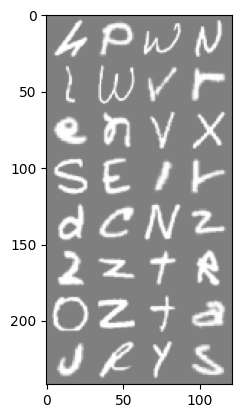

h     l     e     s     d     z     o     j     p     w     n     e     c     z     z     r     w     v     v     i     n     t     t     y     n     r     x     v     z     r     a     s    


In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{train_set.classes[labels[j]]:5s}' for j in range(batch_size)))

# Clasificamos imágenes (Red densa vs convolucional)

Ahora, armemos una red densa para la clasificación de imágenes

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 26)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
net = DenseNet()
net.to(device)

DenseNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=26, bias=True)
)

Entrenamos y evaluamos 

In [15]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

In [16]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) - 1
        # Restamos 1 para que las clases vayan de 0 a 25, en vez de 1 a 26.

        optimizer.zero_grad() # Reiniciamos los gradientes.

        outputs = net(inputs) # Hacemos la pasada forward.
        loss = criterion(outputs, labels) # Calculamos la pérdida.
        loss.backward() # Hacemos la pasada backward.
        optimizer.step() # Actualizamos los pesos.

        running_loss += loss.item() * inputs.shape[0]

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss / total

    # Veamos en validación.
    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad(): # Esta parte es sólo validación, no requiere entrenar, por lo que no calculamos gradientes.
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device) - 1
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # La ganadora es la que tiene mayor valor.
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * images.shape[0]

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1 } finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

print('Finished training.')

Epoch 1 finished. Train accuracy: 71.01%. Validation accuracy: 84.97%.
Epoch 2 finished. Train accuracy: 87.83%. Validation accuracy: 87.50%.
Finished training.


In [17]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) - 1
        # Restamos 1 para que las clases vayan de 0 a 25, en vez de 1 a 26.

        optimizer.zero_grad() # Reiniciamos los gradientes.

        outputs = net(inputs) # Hacemos la pasada forward.
        loss = criterion(outputs, labels) # Calculamos la pérdida.
        loss.backward() # Hacemos la pasada backward.
        optimizer.step() # Actualizamos los pesos.

        running_loss += loss.item() * inputs.shape[0]

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss / total

    # Veamos en validación.
    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad(): # Esta parte es sólo validación, no requiere entrenar, por lo que no calculamos gradientes.
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device) - 1
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # La ganadora es la que tiene mayor valor.
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * images.shape[0]

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1 } finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

print('Finished training.')

Epoch 1 finished. Train accuracy: 90.30%. Validation accuracy: 89.57%.
Epoch 2 finished. Train accuracy: 91.64%. Validation accuracy: 89.95%.
Finished training.


Evaluamos en el conjunto de test

Test accuracy: 89.80%.
Predicted:  a     a     a     a     a    
Ground truth:  a     a     a     a     a    


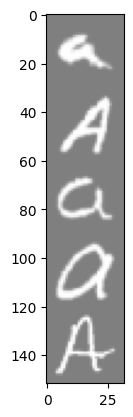

In [19]:
# Calculamos el accuracy para todo el conjunto de test.
correct = 0
total = 0

first_predicted = None
first_labels = None
first_images = None

with torch.no_grad(): # No necesitamos calcular gradientes.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) - 1 # Recordar restar 1 a las etiquetas.
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        if first_predicted is None:
            first_predicted = predicted
            first_labels = labels
            first_images = images
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Test accuracy: {accuracy:.2f}%.')

print('Predicted: ', ' '.join(f'{test_set.classes[first_predicted[j] + 1]:5s}' for j in range(5)))
print('Ground truth: ', ' '.join(f'{test_set.classes[first_labels[j] + 1]:5s}' for j in range(5)))

# Lo vemos sólo para las primeras 5 imágenes.
imshow(torchvision.utils.make_grid(first_images[:5].cpu()))

## Probemos una red convolucional

Reemplazar la red densa por una red convolucional que aproveche la estructura espacial de la imagen, **sin aplanarla desde el inicio**. La red debe cumplir con los siguientes requisitos:

- Tener **dos capas convolucionales**:
  - La **primera** debe recibir imágenes de **1 canal** y producir **32 canales**.
  - La **segunda** debe recibir los **32 canales** y producir **64 canales**.
  - Ambas deben usar un **kernel de 3x3**, **stride 1** y **padding 1**.

- Después de **cada capa convolucional**, debe aplicarse:
  - Una función de activación **LeakyReLU**.
  - Una operación de **max pooling** de tamaño **2x2** y **stride 2**.

- Luego de las convoluciones y el aplanamiento:
  - Agregar una **capa lineal** que reciba la salida de las convoluciones (de tamaño **64×7×7**) y la proyecte a **128 unidades**.
  - Usar nuevamente una **activación LeakyReLU**.
  - Finalmente, agregar una **capa lineal de salida** con **26 unidades**, una por cada clase del conjunto **EMNIST Letters**.

> ✏️ **Recordar calcular bien el tamaño de entrada para la capa lineal según el efecto del pooling sobre las dimensiones espaciales.**


In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act = nn.LeakyReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.caplin = nn.Linear(in_features=64*7*7, out_features=128)
        self.capout = nn.Linear(in_features=128, out_features=26)

    def forward(self, x):
        '''
        (28, 28, 1) -> (28, 28, 32) -> (14, 14, 32)
        (14, 14, 32) -> (14, 14, 64) -> (7, 7, 64)
        '''
        out = self.conv1(x)
        out = self.act(out)
        out = self.max_pool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.max_pool(out)

        out = self.flatten(out)

        out = self.caplin(out)
        out = self.act(out)

        return self.capout(out)

In [24]:
net = CNN()
net.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act): LeakyReLU(negative_slope=0.01)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (caplin): Linear(in_features=3136, out_features=128, bias=True)
  (capout): Linear(in_features=128, out_features=26, bias=True)
)

Entrenamos y evaluamos como lo hicimos con la red densa

In [25]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) - 1

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss/total

    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device) - 1
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * inputs.shape[0]

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1} finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

print('Finished training.')

Epoch 1 finished. Train accuracy: 82.40%. Validation accuracy: 90.37%.
Epoch 2 finished. Train accuracy: 91.97%. Validation accuracy: 91.35%.
Finished training.


In [26]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) - 1

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss/total

    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device) - 1
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * inputs.shape[0]

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1} finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

print('Finished training.')

Epoch 1 finished. Train accuracy: 93.32%. Validation accuracy: 92.53%.
Epoch 2 finished. Train accuracy: 94.13%. Validation accuracy: 92.71%.
Finished training.


Evaluamos en el conjunto de test

Test accuracy: 92.75%.
Predicted:  a     a     a     a     a    
Ground truth:  a     a     a     a     a    


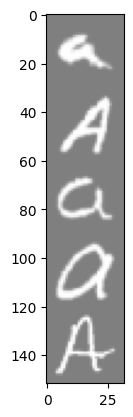

In [27]:
correct = 0
total = 0

first_predicted = None
first_labels = None
first_images = None

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) - 1
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        if first_predicted is None:
            first_predicted = predicted
            first_labels = labels
            first_images = images
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Test accuracy: {accuracy:.2f}%.')

print('Predicted: ', ' '.join(f'{test_set.classes[first_predicted[j] + 1]:5s}' for j in range(5)))
print('Ground truth: ', ' '.join(f'{test_set.classes[first_labels[j] + 1]:5s}' for j in range(5)))

imshow(torchvision.utils.make_grid(first_images[:5].cpu()))

**Pregunta:** ¿Cuál tuvo mejor performance? yeah

# ¿Podemos interpretar a la red convolucional?

En esta parte queremos entender qué está haciendo la red, para eso vamos a visualizar los filtros y cómo se aplican a la imagen. 

In [28]:
from torchvision import utils

# ch = canal que queremos ver

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1, normalize = False):
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h) # -1 dice "no sé cuál es el valor de este parámetro, calculalo"
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  tensor = tensor[:32] # no mostramos más de 32 filtros

  rows = np.min((tensor.shape[0] // nrow + 1, 16))
  grid = utils.make_grid(tensor, nrow=nrow, normalize = normalize, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

Visualizamos los filtros de la primera capa (9x9) para el canal 0 (estamos en escala de grises)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0138811..0.879478].


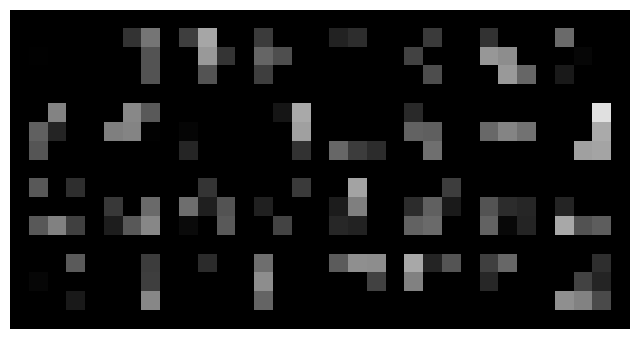

In [29]:
filter = net.conv1.weight.data.clone()
visTensor(filter.cpu(), ch=0, allkernels=True, normalize = False)

plt.axis('off')
plt.ioff()
plt.show()

También podemos visualizamor los filtros de la segunda capa (3x3)


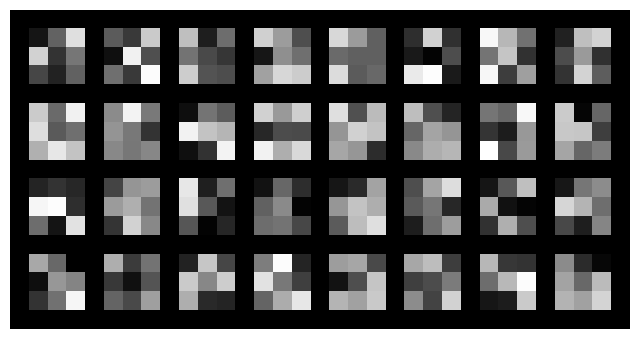

In [30]:
filter = net.conv2.weight.data.clone()
visTensor(filter.cpu(), normalize = True, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

Los filtros no son demasiado claros. Pero, podemos ver cómo se activan si pasamos una imagen. Por ejemplo, podemos elegir la siguiente imagen:

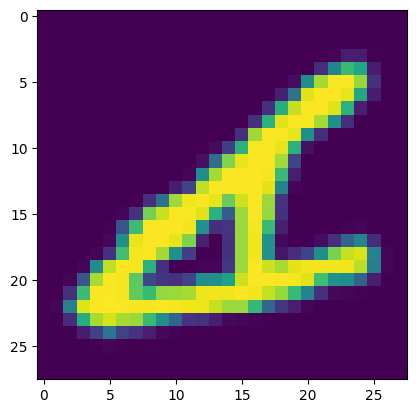

In [31]:
plt.imshow(first_images[1].cpu().squeeze(), cmap='viridis')
plt.show()

In [33]:
# Pass image through the first convolutional layer
conv_layers = [net.conv1, net.max_pool, net.act, net.conv2, net.max_pool]
conv_out = [net.conv1(first_images[1])]
# Iteratively pass image through all convolutional layers
for i in range(1, len(conv_layers)):
  conv_out.append(conv_layers[i](conv_out[-1]))

In [34]:
conv_out[0].shape

torch.Size([32, 28, 28])

In [35]:
def imshow_grid(img, ax, cmap = 'gray', vmin = None):
    img = img / 2 + 0.5 # Desnormalizamos.
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.rot90(npimg, 3)
    npimg = np.fliplr(npimg)
    ax.imshow(npimg, cmap = cmap, vmin = vmin)

Vemos cómo se activa el primer filtro de las redes convolucionales. Es decir, visualizamos el primer mapa de activación resultante de la primera capa

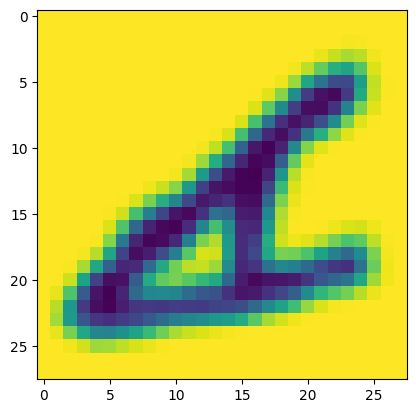

In [36]:
plt.imshow(conv_out[0][0].detach().cpu().squeeze(), cmap='viridis')
plt.show()

O cómo se activa el segundo filtro de las capas convolucionales, es decir, el segundo mapa de activación resultante de la primera capa convolucional:

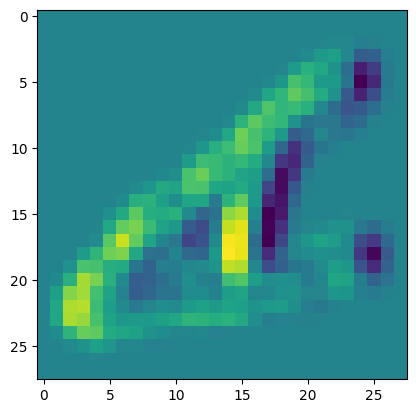

In [37]:
plt.imshow(conv_out[0][1].detach().cpu().squeeze(), cmap='viridis')
plt.show()

Podemos ver cómo se activan los primeros 16 filtros de la primer capa convolucional:

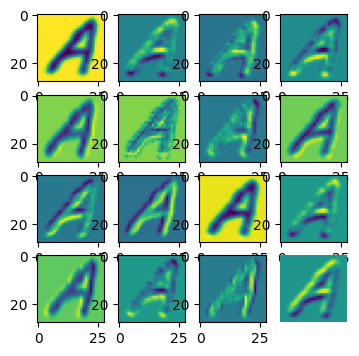

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(4, 4))
fig.gca().set_axis_off()
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())
axs = axs.flatten()
for i in range(0, 16):
  imshow_grid(conv_out[0][i].detach().cpu().unsqueeze(0), axs[i], cmap='viridis')
plt.show()

**Ejercicio**: Visualizar qué pasa después del primer max pool

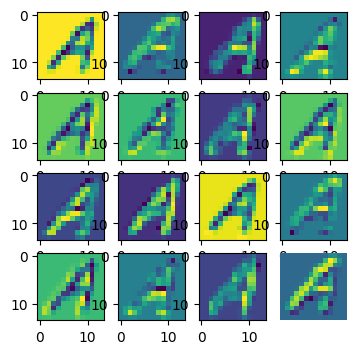

In [44]:
# Visualizamos los primeros 16 mapas de activación después del primer max pool
fig, axs = plt.subplots(4, 4, figsize=(4, 4))
fig.gca().set_axis_off()
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())
axs = axs.flatten()
for i in range(16):
    imshow_grid(conv_out[1][i].detach().cpu().unsqueeze(0), axs[i], cmap='viridis')
plt.show()